### Plotting relative AAs and PTMs in PEAKS DN and PeaksDB results using python for _T. weissflogii_ rot experiment

Starting with:

    Peaks de novo results of PTM-optimized sequencing
    PeaksDB de novo-assisted results from PTM-optimized database searches

Goal:

    Figures comparing the modifcation type and extent in database and de novo peptides
    
Using:

    - pandas
    - matplotlib
    - numpy

In [1]:
# LIBRARIES
#import pandas library for working with tabular data
import os
os.getcwd()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
#import regular expresson (regex)
import re
#check pandas version
pd.__version__

'1.0.5'

### NAAF-corrected residue modification and AA composition across sample set

In [2]:
# for each of the 8 rot LCMS samples:
# read in NAAF totals that are combinations of PeaksDB and PeaksDN (see NAAF-combination nb)


sum_322 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-322.csv")
sum_323 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-323.csv")
sum_324 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-324.csv")
sum_325 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-325.csv")


frames = [sum_322, sum_323, sum_324, sum_325]
index = ['1. T0', '2. T2', '3. T5', '4. T12']

# concatenate dataframes
tot = pd.concat(frames, sort=False, ignore_index=True)

# there's a useless column in there
tot = tot.loc[:, ~tot.columns.str.contains('^Unnamed')]

# reindex with sample names
names = ['T0', 'T2', 'T5', 'T12']
tot.insert(loc=0, column='sample', value=names)
tot.set_index('sample')

# separate out the dataframe into AAs and %PTMs, too
sum_AA = tot[['sample', 'A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', 'G-NAAF', 'H-NAAF', 'I-NAAF', 'K-NAAF', \
              'L-NAAF', 'M-NAAF', 'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', 'T-NAAF', 'V-NAAF', \
              'W-NAAF', 'Y-NAAF']].copy()

sum_ptm = tot[['sample', 'Cys. w/ carb.', 'Met. w/ oxid.', 'Lys. w/ oxid.', 'Pro. w/ oxid.', \
               'Arg. w/ oxid.', 'Tyr. w/ oxid.', 'Asn. w/ deam.', 'Lys. w/ meth.', \
               'Arg. w/ meth.', 'Glu. w/ pyro.', 'Lys. w/ acet.']].copy()

# I think the 'overall modfied' is too biased by terminal residues to be meaningful
#sum_ptm = tot[['sample', 'Cys. w/ carb.', 'Met. w/ oxid.', 'Asn. w/ deam.', 'Gln. w/ deam.', 'Lys. w/ hydr.', \
               #'Arg. w/ meth.', 'Overall modified']].copy()

sum_ptm.head()

,sample,Cys. w/ carb.,Met. w/ oxid.,Lys. w/ oxid.,Pro. w/ oxid.,Arg. w/ oxid.,Tyr. w/ oxid.,Asn. w/ deam.,Lys. w/ meth.,Arg. w/ meth.,Glu. w/ pyro.,Lys. w/ acet.
0,T0,1.0,0.351226,0.144470,0.140332,0.060979,0.304422,0.265141,0.126126,0.014965,0.008627,0.113429
1,T2,1.0,0.661696,0.106449,0.180364,0.096542,0.158877,0.286193,0.080027,0.032300,0.164729,0.142387
2,T5,1.0,0.360411,0.098796,0.145497,0.134163,0.326853,0.450363,0.043161,0.029921,0.030896,0.118290
3,T12,1.0,0.569007,0.081890,0.153991,0.133268,0.226007,0.351315,0.221314,0.040063,0.060431,0.144682


In [3]:
# for each of the 4 undigested rot LCMS samples:
# read in NAAF totals that are combinations of PeaksDB and PeaksDN (see NAAF-combination nb)


sum_329 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-329.csv")
sum_330 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-330.csv")
sum_331 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-331.csv")
sum_332 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-332.csv")


frames = [sum_329, sum_330, sum_331, sum_332]
index = ['T0', 'T2', 'T5', 'T12']

# concatenate dataframes
tot = pd.concat(frames, sort=False, ignore_index=True)

# there's a useless column in there
tot = tot.loc[:, ~tot.columns.str.contains('^Unnamed')]

# reindex with sample names
names = ['T0', 'T2', 'T5', 'T12']
tot.insert(loc=0, column='sample', value=names)
tot.set_index('sample')

# separate out the dataframe into AAs and %PTMs, too
sum_AA_undig = tot[['sample', 'A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', 'G-NAAF', 'H-NAAF', 'I-NAAF', 'K-NAAF', \
              'L-NAAF', 'M-NAAF', 'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', 'T-NAAF', 'V-NAAF', \
              'W-NAAF', 'Y-NAAF']].copy()

sum_ptm_undig = tot[['sample', 'Cys. w/ carb.', 'Met. w/ oxid.', 'Lys. w/ oxid.', 'Pro. w/ oxid.', \
               'Arg. w/ oxid.', 'Tyr. w/ oxid.', 'Asn. w/ deam.', 'Lys. w/ meth.', \
               'Arg. w/ meth.', 'Glu. w/ pyro.', 'Lys. w/ acet.']].copy()

# I think the 'overall modfied' is too biased by terminal residues to be meaningful
#sum_ptm = tot[['sample', 'Cys. w/ carb.', 'Met. w/ oxid.', 'Asn. w/ deam.', 'Gln. w/ deam.', 'Lys. w/ hydr.', \
               #'Arg. w/ meth.', 'Overall modified']].copy()

sum_ptm_undig.head()

,sample,Cys. w/ carb.,Met. w/ oxid.,Lys. w/ oxid.,Pro. w/ oxid.,Arg. w/ oxid.,Tyr. w/ oxid.,Asn. w/ deam.,Lys. w/ meth.,Arg. w/ meth.,Glu. w/ pyro.,Lys. w/ acet.
0,T0,1.0,0.697309,0.056681,0.186296,0.093682,0.182296,0.594858,0.118455,0.077425,0.024906,0.052905
1,T2,1.0,0.662623,0.091989,0.169389,0.061901,0.145880,0.263626,0.131154,0.105596,0.156316,0.102325
2,T5,1.0,0.441837,0.038780,0.064466,0.068603,0.030288,0.827840,0.092393,0.224072,0.004706,0.102695
3,T12,1.0,0.255895,0.116658,0.115927,0.101001,0.033437,0.737515,0.119172,0.167419,0.011080,0.125581


### 1. Peptide modifications:

<Figure size 720x360 with 0 Axes>

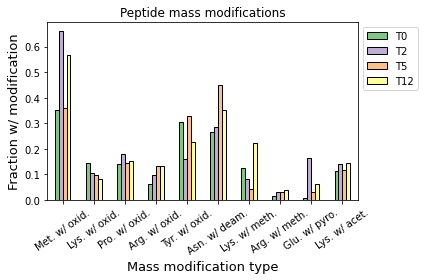

In [4]:
# plot mods across the dataset

sum_ptm_s = sum_ptm.drop(['sample'], axis=1)

ptm_sumT = sum_ptm_s.T

ptm_sumT.columns = ['T0', 'T2', 'T5', 'T12']

four_colors = ['#d53e4f', '#fc8d59', '#fee08b', '#e6f598']
six_colors = ['#d53e4f', '#fc8d59', '#fee08b', '#e6f598', '#99d594', '#3288bd']
six_colors_q = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f']
seven_colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f', '#bf5b17']

fig = plt.figure(figsize = (10, 5)) 

ax = ptm_sumT.iloc[1:11].plot(kind="bar", title = 'Peptide mass modifications', \
                             color = seven_colors, edgecolor = 'black')

plt.xticks(rotation=35)

ax.set_ylabel('Fraction w/ modification', fontsize = 13)
ax.set_xlabel('Mass modification type', fontsize = 13)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
#legend.get_frame().set_edgecolor('1.0')

plt.tight_layout()

plt.savefig("/home/millieginty/Documents/git-repos/rot-mayer/analyses/AA-composition/NAAF-digested-PTM-combined.png", dpi = 300)

#also save in latex manuscript dir
#plt.savefig("/home/millieginty/Documents/git-repos/denovo-etnp/NAAF-ETNP-PTM-combined.png", dpi = 300)

<Figure size 720x360 with 0 Axes>

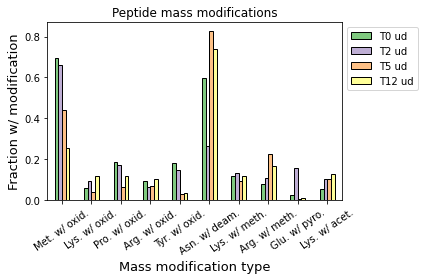

In [5]:
# plot mods across the dataset (undigested)

sum_ptm_undig_s = sum_ptm_undig.drop(['sample'], axis=1)

ptm_sumT_undig = sum_ptm_undig_s.T

ptm_sumT_undig.columns = ['T0 ud', 'T2 ud', 'T5 ud', 'T12 ud']

four_colors = ['#d53e4f', '#fc8d59', '#fee08b', '#e6f598']
six_colors = ['#d53e4f', '#fc8d59', '#fee08b', '#e6f598', '#99d594', '#3288bd']
six_colors_q = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f']
seven_colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f', '#bf5b17']

fig = plt.figure(figsize = (10, 5)) 

ax = ptm_sumT_undig.iloc[1:11].plot(kind="bar", title = 'Peptide mass modifications', \
                             color = seven_colors, edgecolor = 'black')

plt.xticks(rotation=35)

ax.set_ylabel('Fraction w/ modification', fontsize = 13)
ax.set_xlabel('Mass modification type', fontsize = 13)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
#legend.get_frame().set_edgecolor('1.0')

plt.tight_layout()

plt.savefig("/home/millieginty/Documents/git-repos/rot-mayer/analyses/AA-composition/NAAF-undigested-PTM-combined.png", dpi = 300)

#also save in latex manuscript dir
#plt.savefig("/home/millieginty/Documents/git-repos/denovo-etnp/NAAF-ETNP-PTM-combined.png", dpi = 300)

In [6]:
ptm_sumT.head(11)

,T0,T2,T5,T12
Cys. w/ carb.,1.000000,1.000000,1.000000,1.000000
Met. w/ oxid.,0.351226,0.661696,0.360411,0.569007
Lys. w/ oxid.,0.144470,0.106449,0.098796,0.081890
Pro. w/ oxid.,0.140332,0.180364,0.145497,0.153991
Arg. w/ oxid.,0.060979,0.096542,0.134163,0.133268
Tyr. w/ oxid.,0.304422,0.158877,0.326853,0.226007
Asn. w/ deam.,0.265141,0.286193,0.450363,0.351315
Lys. w/ meth.,0.126126,0.080027,0.043161,0.221314
Arg. w/ meth.,0.014965,0.032300,0.029921,0.040063
Glu. w/ pyro.,0.008627,0.164729,0.030896,0.060431


In [7]:
ptm_sumT_undig.head(11)

,T0 ud,T2 ud,T5 ud,T12 ud
Cys. w/ carb.,1.000000,1.000000,1.000000,1.000000
Met. w/ oxid.,0.697309,0.662623,0.441837,0.255895
Lys. w/ oxid.,0.056681,0.091989,0.038780,0.116658
Pro. w/ oxid.,0.186296,0.169389,0.064466,0.115927
Arg. w/ oxid.,0.093682,0.061901,0.068603,0.101001
Tyr. w/ oxid.,0.182296,0.145880,0.030288,0.033437
Asn. w/ deam.,0.594858,0.263626,0.827840,0.737515
Lys. w/ meth.,0.118455,0.131154,0.092393,0.119172
Arg. w/ meth.,0.077425,0.105596,0.224072,0.167419
Glu. w/ pyro.,0.024906,0.156316,0.004706,0.011080


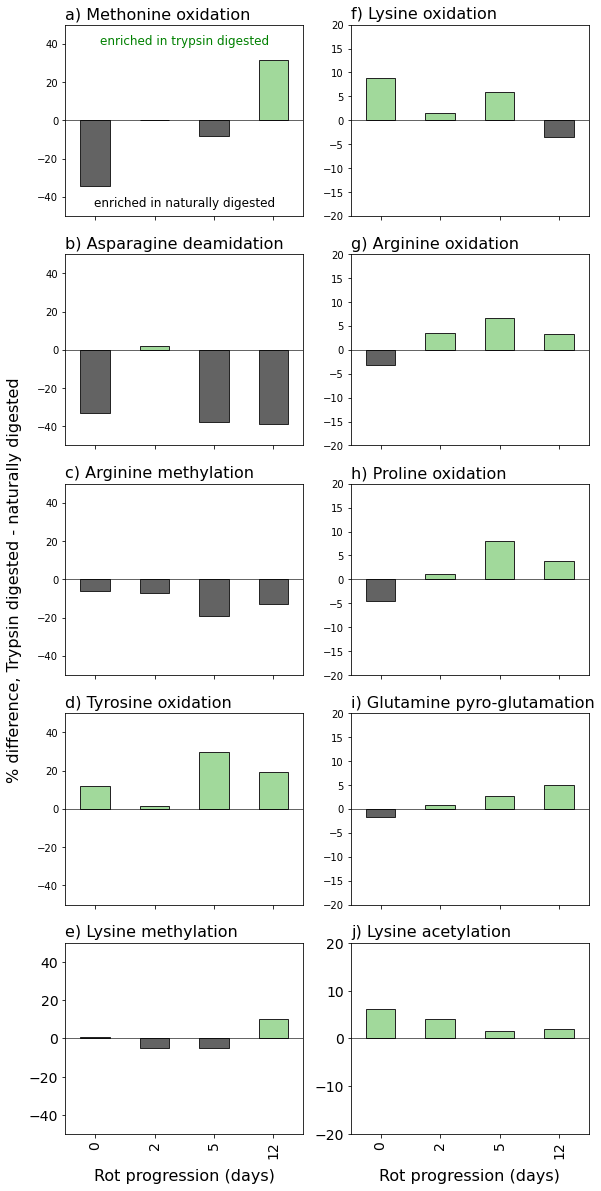

In [8]:
# add the two dataframes

diff = pd.concat([ptm_sumT, ptm_sumT_undig], axis=1)

diff['Day 0'] = (diff['T0'] - diff['T0 ud'])*100
diff['Day 2'] = (diff['T2'] - diff['T2 ud'])*100
diff['Day 5'] = (diff['T5'] - diff['T5 ud'])*100
diff['Day 12'] = (diff['T12'] - diff['T12 ud'])*100

# transpose and delete non diff columns

del diff['T0']
del diff['T2']
del diff['T5']
del diff['T12']

del diff['T0 ud']
del diff['T2 ud']
del diff['T5 ud']
del diff['T12 ud']

diff_plot = diff.T

# add column of Day #s
diff_plot['Day'] = [0, 2, 5, 12]

fig, axes = plt.subplots(figsize=(8, 16),nrows=5, ncols=2, sharex = True)
plt.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)

# 

axes[0,0].annotate('enriched in trypsin digested', xy=(0.5, 0.4), 
            xytext=(0.5, 0.95), textcoords='axes fraction',
            color='green', fontsize=12,
            horizontalalignment='center', verticalalignment='top'
            )

axes[0,0].annotate('enriched in naturally digested', xy=(0.5, 0.4), 
            xytext=(0.5, 0.1), textcoords='axes fraction',
            color='black', fontsize=12,
            horizontalalignment='center', verticalalignment='top'
            )


#  Methionine oxidation
diff_plot.plot(ax = axes[0,0], x="Day", y="Met. w/ oxid.", kind='bar', stacked=False, edgecolor = '#252525', \
              color=(diff_plot['Met. w/ oxid.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[0,0].set_title('a) Methonine oxidation', fontsize = 16, loc='left')
axes[0,0].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[0,0].get_legend().remove()
axes[0,0].set_ylim([-50, 50])


# Lysine oxidation
diff_plot.plot(ax = axes[0,1], x="Day", y="Lys. w/ oxid.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Lys. w/ oxid.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[0,1].set_title('f) Lysine oxidation', fontsize = 16, loc='left')
axes[0,1].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[0,1].get_legend().remove()
axes[0,1].set_ylim([-20, 20])

# Proline oxidation
diff_plot.plot(ax = axes[2,1], x="Day", y="Pro. w/ oxid.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Pro. w/ oxid.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[2,1].set_title('h) Proline oxidation', fontsize = 16, loc='left')
axes[2,1].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[2,1].get_legend().remove()
axes[2,1].set_ylim([-20, 20])

# Arginine oxidation
diff_plot.plot(ax = axes[1,1], x="Day", y="Arg. w/ oxid.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Arg. w/ oxid.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[1,1].set_title('g) Arginine oxidation', fontsize = 16, loc='left')
axes[1,1].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[1,1].get_legend().remove()
axes[1,1].set_ylim([-20, 20])

# Tyrosine oxidation
diff_plot.plot(ax = axes[3,0], x="Day", y="Tyr. w/ oxid.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Tyr. w/ oxid.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[3,0].set_title('d) Tyrosine oxidation', fontsize = 16, loc='left')
axes[3,0].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[3,0].get_legend().remove()
axes[3,0].set_ylim([-50, 50])

# Asparagine deamidation
diff_plot.plot(ax = axes[1,0], x="Day", y="Asn. w/ deam.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Asn. w/ deam.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[1,0].set_title('b) Asparagine deamidation', fontsize = 16, loc='left')
axes[1,0].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[1,0].get_legend().remove()
axes[1,0].set_ylim([-50, 50])

# Lysine methylation
diff_plot.plot(ax = axes[4,0], x="Day", y="Lys. w/ meth.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Lys. w/ meth.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[4,0].set_title('e) Lysine methylation', fontsize = 16, loc='left')
axes[4,0].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[4,0].get_legend().remove()
axes[4,0].set_ylim([-50, 50])
axes[4,0].set_xlabel("Rot progression (days)", fontsize = 16, labelpad = 10)
axes[4,0].tick_params(labelsize= 14)

# Arginine methylation
diff_plot.plot(ax = axes[2,0], x="Day", y="Arg. w/ meth.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Arg. w/ meth.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[2,0].set_title('c) Arginine methylation', fontsize = 16, loc='left')
axes[2,0].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[2,0].get_legend().remove()
axes[2,0].set_ylim([-50, 50])

# Label the y axes

axes[2,0].set_ylabel("% difference, Trypsin digested - naturally digested", fontsize = 16, labelpad = 15)

# Glutamine pyro-gluatmation
diff_plot.plot(ax = axes[3,1], x="Day", y="Glu. w/ pyro.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Glu. w/ pyro.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[3,1].set_title('i) Glutamine pyro-glutamation', fontsize = 16, loc='left')
axes[3,1].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[3,1].get_legend().remove()
axes[3,1].set_ylim([-20, 20])

# Lysine acetylation
diff_plot.plot(ax = axes[4,1], x="Day", y="Lys. w/ acet.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Lys. w/ acet.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[4,1].set_title('j) Lysine acetylation', fontsize = 16, loc='left')
axes[4,1].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[4,1].get_legend().remove()
axes[4,1].set_ylim([-20, 20])
axes[4,1].set_xlabel("Rot progression (days)", fontsize = 16, labelpad = 10)
axes[4,1].tick_params(labelsize= 14)

## NAAF-adjusted amino acid composition 

### Combined DB and DN peptide AAs

In [9]:
# made this dataframe above
# it's just the digeseted peptides AAs
sum_AA.head()

,sample,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,I-NAAF,K-NAAF,...,M-NAAF,N-NAAF,P-NAAF,Q-NAAF,R-NAAF,S-NAAF,T-NAAF,V-NAAF,W-NAAF,Y-NAAF
0,T0,4483.273061,222.045981,1872.609403,3238.356483,1296.870742,3203.344206,493.114222,620.656959,2464.677611,...,1161.285587,4251.047950,4767.331043,905.847832,4963.595836,5291.033126,4026.936445,4907.572835,346.355632,743.084583
1,T2,3881.416898,716.713925,2424.339348,5453.444338,1180.023355,3016.917688,516.187340,676.119865,4373.144017,...,937.950321,3051.378342,5488.841208,1607.697217,4461.168188,3855.640776,4570.723079,7470.273995,504.414659,865.446460
2,T5,3056.788644,219.868175,2189.512665,3601.122169,1774.418803,3483.013518,362.410636,515.555154,2586.820736,...,1157.421905,3722.132854,3317.402609,865.600261,3552.270564,1213.738378,2483.729196,2495.749088,322.784385,1339.915341
3,T12,3887.913626,208.235777,3510.888104,4197.227523,2514.903533,4182.793845,289.667273,271.810998,3400.099060,...,1833.093289,3954.324481,3562.708741,1113.701898,5112.029372,1908.095207,3727.429438,4285.715116,652.409194,909.507649


In [10]:
# sum all the AAs in each dataset, making a new column

sum_AA['AA-Total-NAAF'] = sum_AA['A-NAAF'] + sum_AA['C-NAAF'] + sum_AA['D-NAAF'] + sum_AA['E-NAAF'] \
+ sum_AA['F-NAAF'] + sum_AA['G-NAAF'] + sum_AA['H-NAAF'] + sum_AA['K-NAAF'] + sum_AA['I-NAAF'] + sum_AA['L-NAAF'] \
+ sum_AA['M-NAAF'] + sum_AA['N-NAAF'] + sum_AA['P-NAAF'] + sum_AA['Q-NAAF'] + sum_AA['R-NAAF'] \
+ sum_AA['S-NAAF'] + sum_AA['T-NAAF'] + sum_AA['V-NAAF'] + sum_AA['W-NAAF'] + sum_AA['Y-NAAF'] \

# calculate the relative (NAAF-normalized) AA composition (fractions of AA total for each dataset)

sum_AA['A_RelNAAF'] = sum_AA['A-NAAF']/sum_AA['AA-Total-NAAF']  #A
sum_AA['C_RelNAAF'] = sum_AA['C-NAAF']/sum_AA['AA-Total-NAAF']  #C
sum_AA['D_RelNAAF'] = sum_AA['D-NAAF']/sum_AA['AA-Total-NAAF']  #D
sum_AA['E_RelNAAF'] = sum_AA['E-NAAF']/sum_AA['AA-Total-NAAF']  #E
sum_AA['F_RelNAAF'] = sum_AA['F-NAAF']/sum_AA['AA-Total-NAAF']  #F
sum_AA['G_RelNAAF'] = sum_AA['G-NAAF']/sum_AA['AA-Total-NAAF']  #G
sum_AA['H_RelNAAF'] = sum_AA['H-NAAF']/sum_AA['AA-Total-NAAF']  #H
sum_AA['K_RelNAAF'] = sum_AA['K-NAAF']/sum_AA['AA-Total-NAAF']  #K
sum_AA['I/L_RelNAAF'] = (sum_AA['I-NAAF'] + sum_AA['L-NAAF'])/sum_AA['AA-Total-NAAF']  #I/L
sum_AA['M_RelNAAF'] = sum_AA['M-NAAF']/sum_AA['AA-Total-NAAF']  #M
sum_AA['N_RelNAAF'] = sum_AA['N-NAAF']/sum_AA['AA-Total-NAAF']  #N
sum_AA['P_RelNAAF'] = sum_AA['P-NAAF']/sum_AA['AA-Total-NAAF']  #P
sum_AA['Q_RelNAAF'] = sum_AA['Q-NAAF']/sum_AA['AA-Total-NAAF']  #Q
sum_AA['R_RelNAAF'] = sum_AA['R-NAAF']/sum_AA['AA-Total-NAAF']  #R
sum_AA['S_RelNAAF'] = sum_AA['S-NAAF']/sum_AA['AA-Total-NAAF']  #S
sum_AA['T_RelNAAF'] = sum_AA['T-NAAF']/sum_AA['AA-Total-NAAF']  #T
sum_AA['V_RelNAAF'] = sum_AA['V-NAAF']/sum_AA['AA-Total-NAAF']  #V
sum_AA['W_RelNAAF'] = sum_AA['W-NAAF']/sum_AA['AA-Total-NAAF']  #W
sum_AA['Y_RelNAAF'] = sum_AA['Y-NAAF']/sum_AA['AA-Total-NAAF']  #Y

# make a smaller dataframe with just the relative, NAAF-normalized AA compositions
sum_relAA = sum_AA[['sample', 'A_RelNAAF', 'C_RelNAAF', 'D_RelNAAF', 'E_RelNAAF', 'F_RelNAAF', 'G_RelNAAF', 'H_RelNAAF', \
                      'K_RelNAAF', 'I/L_RelNAAF', 'M_RelNAAF', 'N_RelNAAF', 'P_RelNAAF', 'Q_RelNAAF', 'R_RelNAAF', \
                      'S_RelNAAF', 'T_RelNAAF', 'V_RelNAAF', 'W_RelNAAF', 'Y_RelNAAF']].copy()

#export as a csv

sum_relAA.to_csv("/home/millieginty/Documents/git-repos/rot-mayer/analyses/AA-composition/digested-DB+DN-RelNAAF-AAs.csv")

sum_relAA.head(6)

,sample,A_RelNAAF,C_RelNAAF,D_RelNAAF,E_RelNAAF,F_RelNAAF,G_RelNAAF,H_RelNAAF,K_RelNAAF,I/L_RelNAAF,M_RelNAAF,N_RelNAAF,P_RelNAAF,Q_RelNAAF,R_RelNAAF,S_RelNAAF,T_RelNAAF,V_RelNAAF,W_RelNAAF,Y_RelNAAF
0,T0,0.077182,0.003823,0.032238,0.055750,0.022326,0.055147,0.008489,0.042431,0.162666,0.019992,0.073184,0.082072,0.015595,0.085451,0.091088,0.069326,0.084486,0.005963,0.012793
1,T2,0.062271,0.011499,0.038895,0.087492,0.018932,0.048402,0.008281,0.070160,0.127627,0.015048,0.048955,0.088060,0.025793,0.071572,0.061858,0.073330,0.119849,0.008093,0.013885
2,T5,0.068643,0.004937,0.049168,0.080867,0.039846,0.078214,0.008138,0.058090,0.152407,0.025991,0.083584,0.074495,0.019438,0.079770,0.027256,0.055775,0.056044,0.007248,0.030089
3,T12,0.068015,0.003643,0.061420,0.073427,0.043996,0.073174,0.005067,0.059482,0.138404,0.032068,0.069177,0.062326,0.019483,0.089430,0.033380,0.065208,0.074975,0.011413,0.015911


In [11]:
# sum all the AAs in each dataset EXCEPT those not included in THAA analyses, making a new column
# THAA doesn't get C, N, Q, and W

sum_AA['AA-Total-NAAF-THAAinc'] = sum_AA['A-NAAF'] + + sum_AA['D-NAAF'] + sum_AA['E-NAAF'] \
+ sum_AA['F-NAAF'] + sum_AA['G-NAAF'] + sum_AA['H-NAAF'] + sum_AA['K-NAAF'] + sum_AA['I-NAAF'] + sum_AA['L-NAAF'] \
+ sum_AA['M-NAAF'] + sum_AA['P-NAAF'] + sum_AA['R-NAAF'] \
+ sum_AA['S-NAAF'] + sum_AA['T-NAAF'] + sum_AA['V-NAAF'] + sum_AA['Y-NAAF'] \

# calculate the relative (NAAF-normalized) AA composition (fractions of AA total for each dataset)

sum_AA['A_RelNAAF'] = sum_AA['A-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #A
#sum_AA['C_RelNAAF'] = sum_AA['C-NAAF']/sum_AA['AA-Total-NAAF']  #C
sum_AA['D_RelNAAF'] = sum_AA['D-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #D
sum_AA['E_RelNAAF'] = sum_AA['E-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #E
sum_AA['F_RelNAAF'] = sum_AA['F-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #F
sum_AA['G_RelNAAF'] = sum_AA['G-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #G
sum_AA['H_RelNAAF'] = sum_AA['H-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #H
sum_AA['K_RelNAAF'] = sum_AA['K-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #K
sum_AA['I/L_RelNAAF'] = (sum_AA['I-NAAF'] + sum_AA['L-NAAF'])/sum_AA['AA-Total-NAAF-THAAinc']  #I/L
sum_AA['M_RelNAAF'] = sum_AA['M-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #M
#sum_AA['N_RelNAAF'] = sum_AA['N-NAAF']/sum_AA['AA-Total-NAAF']  #N
sum_AA['P_RelNAAF'] = sum_AA['P-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #P
#sum_AA['Q_RelNAAF'] = sum_AA['Q-NAAF']/sum_AA['AA-Total-NAAF']  #Q
sum_AA['R_RelNAAF'] = sum_AA['R-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #R
sum_AA['S_RelNAAF'] = sum_AA['S-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #S
sum_AA['T_RelNAAF'] = sum_AA['T-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #T
sum_AA['V_RelNAAF'] = sum_AA['V-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #V
#sum_AA['W_RelNAAF'] = sum_AA['W-NAAF']/sum_AA['AA-Total-NAAF']  #W
sum_AA['Y_RelNAAF'] = sum_AA['Y-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #Y

# make a smaller dataframe with just the relative, NAAF-normalized AA compositions (THAA compatible)
DigPep_relAA_THAAcompatible = sum_AA[['sample', 'A_RelNAAF', 'D_RelNAAF', 'E_RelNAAF', 'F_RelNAAF', 'G_RelNAAF', 'H_RelNAAF', \
                      'K_RelNAAF', 'I/L_RelNAAF', 'M_RelNAAF', 'P_RelNAAF', 'R_RelNAAF', \
                      'S_RelNAAF', 'T_RelNAAF', 'V_RelNAAF', 'Y_RelNAAF']].copy()

#export as a csv

DigPep_relAA_THAAcompatible.to_csv("/home/millieginty/Documents/git-repos/rot-mayer/analyses/AA-composition/digested-DB+DN-RelNAAF-AAs-THAAcompatible.csv")

DigPep_relAA_THAAcompatible.head(6)

,sample,A_RelNAAF,D_RelNAAF,E_RelNAAF,F_RelNAAF,G_RelNAAF,H_RelNAAF,K_RelNAAF,I/L_RelNAAF,M_RelNAAF,P_RelNAAF,R_RelNAAF,S_RelNAAF,T_RelNAAF,V_RelNAAF,Y_RelNAAF
0,T0,0.085621,0.035763,0.061846,0.024767,0.061177,0.009417,0.047070,0.180452,0.022178,0.091046,0.094794,0.101047,0.076906,0.093724,0.014191
1,T2,0.068758,0.042946,0.096606,0.020904,0.053443,0.009144,0.077468,0.140921,0.016615,0.097233,0.079028,0.068301,0.080969,0.132333,0.015331
2,T5,0.077581,0.055570,0.091396,0.045035,0.088399,0.009198,0.065653,0.172251,0.029375,0.084195,0.090156,0.030805,0.063037,0.063342,0.034007
3,T12,0.075886,0.068527,0.081923,0.049087,0.081642,0.005654,0.066365,0.154420,0.035779,0.069539,0.099779,0.037243,0.072754,0.083651,0.017752


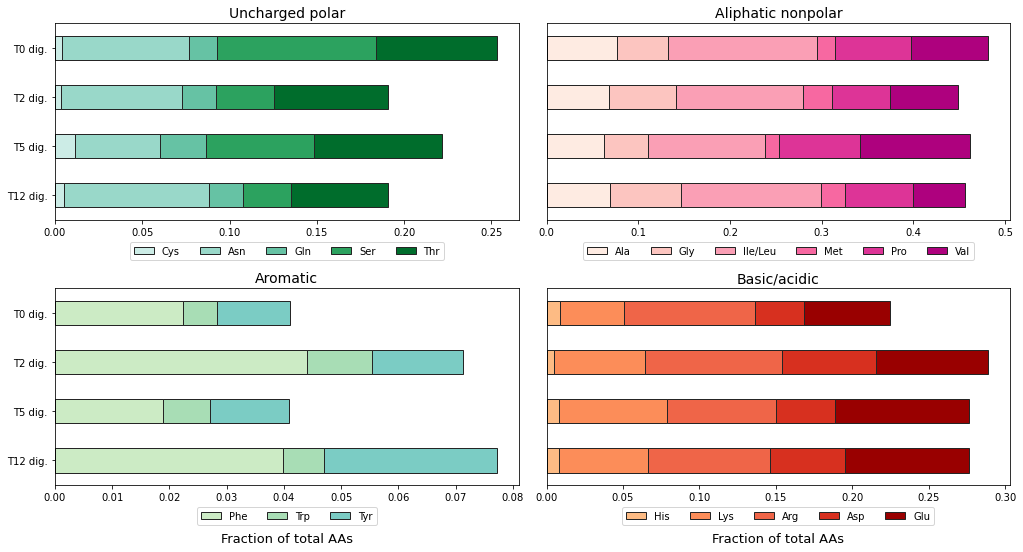

In [12]:
# plotting the NAAF-corrected AA compositions by residue type (charge, side group)
# order the horizontal bars by sample

sum_relAA_des = sum_relAA.sort_values('sample',ascending=False)

col_up = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
col_na = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
col_ar = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
col_ba = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'

# divide up the dataframe into 4 smaller dataframes based on AA class

# uncharged polar: cysteine, asparagine, glutamine, serine, threonine
up = sum_relAA_des[['sample', 'C_RelNAAF', 'N_RelNAAF', 'Q_RelNAAF', 'S_RelNAAF', 'T_RelNAAF']].copy()
up_names = ['sample', 'Cys', 'Asn', 'Gln', 'Ser', 'Thr']
up.columns = up_names

# nonpolar, aliphatic R-group: alanine, glycine, methionine, proline, valine
na = sum_relAA_des[['sample', 'A_RelNAAF', 'G_RelNAAF','I/L_RelNAAF', 'M_RelNAAF',\
                    'P_RelNAAF', 'V_RelNAAF']].copy()
na_names = ['sample', 'Ala', 'Gly', 'Ile/Leu', 'Met', 'Pro', 'Val']
na.columns = na_names

# aromatic R-group: phenylalanine, tryptophan, tyrosine
ar = sum_relAA_des[['sample', 'F_RelNAAF', 'W_RelNAAF', 'Y_RelNAAF']].copy() 
ar_names = ['sample', 'Phe', 'Trp', 'Tyr']
ar.columns = ar_names

# basic and acidic R-group: hisdiine, lysine, arginine, aspartic acid, glutamic acid
ba = sum_relAA_des[['sample', 'H_RelNAAF', 'K_RelNAAF', 'R_RelNAAF', 'D_RelNAAF', 'E_RelNAAF']].copy()
ba_names = ['sample', 'His', 'Lys', 'Arg', 'Asp', 'Glu']
ba.columns = ba_names

# plot AA comps

fig, axes = plt.subplots(figsize=(14, 7),nrows=2, ncols=2)
plt.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace= 0.06, hspace= 0.35)

up.plot(ax=axes[0,0], x='sample', kind='barh', stacked=True, color = col_up, edgecolor = '#252525')
na.plot(ax=axes[0,1], x='sample', kind='barh', stacked=True, color = col_na, edgecolor = '#252525')
ar.plot(ax=axes[1,0], x='sample', kind='barh', stacked=True, color = col_ar, edgecolor = '#252525')
ba.plot(ax=axes[1,1], x='sample', kind='barh', stacked=True, color = col_ba, edgecolor = '#252525')

axes[0,0].set_title('Uncharged polar', fontsize = 14)
axes[0,0].set_ylabel("")
axes[0,0].legend(bbox_to_anchor=(0.5, -0.09), loc='upper center', ncol=5)
axes[0,0].set_yticklabels( ('T12 dig.', 'T5 dig.', 'T2 dig.', 'T0 dig.') )

axes[0,1].set_title('Aliphatic nonpolar', fontsize = 14)
axes[0,1].yaxis.set_ticks([])
axes[0,1].set_ylabel("")
axes[0,1].legend(bbox_to_anchor=(0.5, -0.09), loc='upper center', ncol=6)

axes[1,0].set_title('Aromatic', fontsize = 14)
axes[1,0].set_xlabel('Fraction of total AAs', labelpad = 30, fontsize = 13)
axes[1,0].set_ylabel("")
axes[1,0].legend(bbox_to_anchor=(0.5, -0.09), loc='upper center', ncol=3)
axes[1,0].set_yticklabels( ('T12 dig.', 'T5 dig.', 'T2 dig.', 'T0 dig.') )

axes[1,1].set_title('Basic/acidic', fontsize = 14)
axes[1,1].yaxis.set_ticks([])
axes[1,1].set_xlabel('Fraction of total AAs', labelpad = 30, fontsize = 13)
axes[1,1].set_ylabel("")
axes[1,1].legend(bbox_to_anchor=(0.5, -0.09), loc='upper center', ncol=5)

#fig.suptitle('Relative amino acid composition of ETNP POM peptides', y = 1.07, size = 15)

# save figure in ptm-analyses dir
plt.savefig("/home/millieginty/Documents/git-repos/rot-mayer/analyses/AA-composition/digested-DB+DN-AA-NAAFs.png", dpi = 300, bbox_inches='tight', transparent=True)

# also save in manuscript latex dir high res
#plt.savefig("/home/millieginty/Documents/git-repos/denovo-etnp/ETNP-AAs.png", dpi = 300, bbox_inches='tight')

## Now for the undigested AAs

In [13]:
# made this dataframe above
# it's just the undigeseted peptides AAs
sum_AA_undig.head()

,sample,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,I-NAAF,K-NAAF,...,M-NAAF,N-NAAF,P-NAAF,Q-NAAF,R-NAAF,S-NAAF,T-NAAF,V-NAAF,W-NAAF,Y-NAAF
0,T0,1123.188318,63.150623,1623.563531,1590.882011,873.970296,2359.117168,685.668095,237.602283,819.104048,...,404.408195,1505.599774,2350.590499,488.810093,687.228518,613.010741,1195.428474,1063.238902,101.067887,472.257482
1,T2,3329.100337,74.515359,3490.610652,6801.840911,1721.391465,4316.290718,904.005889,1034.571071,3416.158147,...,1850.344906,3136.252402,5045.096852,1763.538170,1881.679218,1624.001823,3350.224685,4416.412971,166.913269,571.397144
2,T5,553.831240,50.766914,2192.412993,1202.405554,648.249814,2252.599354,1064.718245,268.182024,748.146481,...,409.848456,1548.325592,3002.127366,217.893908,309.519344,290.538141,728.959235,741.347540,59.597377,1072.619669
3,T12,912.726454,19.133144,1698.018143,1012.152056,460.563316,2436.328784,958.019426,89.789919,1291.527737,...,377.329728,1551.212990,3089.718692,330.698357,452.968141,402.008528,753.656446,1320.357700,115.259804,927.375860


In [14]:
# sum all the AAs in each dataset, making a new column

sum_AA_undig['AA-Total-NAAF'] = sum_AA_undig['A-NAAF'] + sum_AA_undig['C-NAAF'] + sum_AA_undig['D-NAAF'] + sum_AA_undig['E-NAAF'] \
+ sum_AA_undig['F-NAAF'] + sum_AA_undig['G-NAAF'] + sum_AA_undig['H-NAAF'] + sum_AA_undig['K-NAAF'] + sum_AA_undig['I-NAAF'] + sum_AA_undig['L-NAAF'] \
+ sum_AA_undig['M-NAAF'] + sum_AA_undig['N-NAAF'] + sum_AA_undig['P-NAAF'] + sum_AA_undig['Q-NAAF'] + sum_AA_undig['R-NAAF'] \
+ sum_AA_undig['S-NAAF'] + sum_AA_undig['T-NAAF'] + sum_AA_undig['V-NAAF'] + sum_AA_undig['W-NAAF'] + sum_AA_undig['Y-NAAF'] \

# calculate the relative (NAAF-normalized) AA composition (fractions of AA total for each dataset)

sum_AA_undig['A_RelNAAF'] = sum_AA_undig['A-NAAF']/sum_AA_undig['AA-Total-NAAF']  #A
sum_AA_undig['C_RelNAAF'] = sum_AA_undig['C-NAAF']/sum_AA_undig['AA-Total-NAAF']  #C
sum_AA_undig['D_RelNAAF'] = sum_AA_undig['D-NAAF']/sum_AA_undig['AA-Total-NAAF']  #D
sum_AA_undig['E_RelNAAF'] = sum_AA_undig['E-NAAF']/sum_AA_undig['AA-Total-NAAF']  #E
sum_AA_undig['F_RelNAAF'] = sum_AA_undig['F-NAAF']/sum_AA_undig['AA-Total-NAAF']  #F
sum_AA_undig['G_RelNAAF'] = sum_AA_undig['G-NAAF']/sum_AA_undig['AA-Total-NAAF']  #G
sum_AA_undig['H_RelNAAF'] = sum_AA_undig['H-NAAF']/sum_AA_undig['AA-Total-NAAF']  #H
sum_AA_undig['K_RelNAAF'] = sum_AA_undig['K-NAAF']/sum_AA_undig['AA-Total-NAAF']  #K
sum_AA_undig['I/L_RelNAAF'] = (sum_AA_undig['I-NAAF'] + sum_AA_undig['L-NAAF'])/sum_AA_undig['AA-Total-NAAF']  #I/L
sum_AA_undig['M_RelNAAF'] = sum_AA_undig['M-NAAF']/sum_AA_undig['AA-Total-NAAF']  #M
sum_AA_undig['N_RelNAAF'] = sum_AA_undig['N-NAAF']/sum_AA_undig['AA-Total-NAAF']  #N
sum_AA_undig['P_RelNAAF'] = sum_AA_undig['P-NAAF']/sum_AA_undig['AA-Total-NAAF']  #P
sum_AA_undig['Q_RelNAAF'] = sum_AA_undig['Q-NAAF']/sum_AA_undig['AA-Total-NAAF']  #Q
sum_AA_undig['R_RelNAAF'] = sum_AA_undig['R-NAAF']/sum_AA_undig['AA-Total-NAAF']  #R
sum_AA_undig['S_RelNAAF'] = sum_AA_undig['S-NAAF']/sum_AA_undig['AA-Total-NAAF']  #S
sum_AA_undig['T_RelNAAF'] = sum_AA_undig['T-NAAF']/sum_AA_undig['AA-Total-NAAF']  #T
sum_AA_undig['V_RelNAAF'] = sum_AA_undig['V-NAAF']/sum_AA_undig['AA-Total-NAAF']  #V
sum_AA_undig['W_RelNAAF'] = sum_AA_undig['W-NAAF']/sum_AA_undig['AA-Total-NAAF']  #W
sum_AA_undig['Y_RelNAAF'] = sum_AA_undig['Y-NAAF']/sum_AA_undig['AA-Total-NAAF']  #Y

# make a smaller dataframe with just the relative, NAAF-normalized AA compositions
sum_relAA_undig = sum_AA_undig[['sample', 'A_RelNAAF', 'C_RelNAAF', 'D_RelNAAF', 'E_RelNAAF', 'F_RelNAAF', 'G_RelNAAF', 'H_RelNAAF', \
                      'K_RelNAAF', 'I/L_RelNAAF', 'M_RelNAAF', 'N_RelNAAF', 'P_RelNAAF', 'Q_RelNAAF', 'R_RelNAAF', \
                      'S_RelNAAF', 'T_RelNAAF', 'V_RelNAAF', 'W_RelNAAF', 'Y_RelNAAF']].copy()

#export as a csv

sum_relAA_undig.to_csv("/home/millieginty/Documents/git-repos/rot-mayer/analyses/AA-composition/undigested-DB+DN-RelNAAF-AAs.csv")

sum_relAA_undig.head(6)

,sample,A_RelNAAF,C_RelNAAF,D_RelNAAF,E_RelNAAF,F_RelNAAF,G_RelNAAF,H_RelNAAF,K_RelNAAF,I/L_RelNAAF,M_RelNAAF,N_RelNAAF,P_RelNAAF,Q_RelNAAF,R_RelNAAF,S_RelNAAF,T_RelNAAF,V_RelNAAF,W_RelNAAF,Y_RelNAAF
0,T0,0.054767,0.003079,0.079166,0.077572,0.042615,0.115032,0.033434,0.039940,0.121322,0.019719,0.073414,0.114616,0.023835,0.033510,0.029891,0.058290,0.051844,0.004928,0.023028
1,T2,0.058885,0.001318,0.061741,0.120310,0.030448,0.076346,0.015990,0.060424,0.153464,0.032729,0.055474,0.089237,0.031193,0.033283,0.028725,0.059258,0.078117,0.002952,0.010107
2,T5,0.026116,0.002394,0.103383,0.056700,0.030568,0.106222,0.050207,0.035279,0.193935,0.019326,0.073011,0.141566,0.010275,0.014595,0.013700,0.034374,0.034958,0.002810,0.050580
3,T12,0.040793,0.000855,0.075891,0.045237,0.020584,0.108889,0.042818,0.057724,0.190633,0.016864,0.069330,0.138092,0.014780,0.020245,0.017967,0.033684,0.059012,0.005151,0.041448


In [15]:
# sum all the AAs in each dataset EXCEPT those not included in THAA analyses, making a new column
# THAA doesn't get C, N, Q, and W

sum_AA_undig['AA-Total-NAAF-THAAinc'] = sum_AA_undig['A-NAAF'] + + sum_AA_undig['D-NAAF'] + sum_AA_undig['E-NAAF'] \
+ sum_AA_undig['F-NAAF'] + sum_AA_undig['G-NAAF'] + sum_AA_undig['H-NAAF'] + sum_AA_undig['K-NAAF'] + sum_AA_undig['I-NAAF'] + sum_AA_undig['L-NAAF'] \
+ sum_AA_undig['M-NAAF'] + sum_AA_undig['P-NAAF'] + sum_AA_undig['R-NAAF'] \
+ sum_AA_undig['S-NAAF'] + sum_AA_undig['T-NAAF'] + sum_AA_undig['V-NAAF'] + sum_AA_undig['Y-NAAF'] \

# calculate the relative (NAAF-normalized) AA composition (fractions of AA total for each dataset)

sum_AA_undig['A_RelNAAF'] = sum_AA_undig['A-NAAF']/sum_AA_undig['AA-Total-NAAF-THAAinc']  #A
#sum_AA_undig['C_RelNAAF'] = sum_AA_undig['C-NAAF']/sum_AA_undig['AA-Total-NAAF']  #C
sum_AA_undig['D_RelNAAF'] = sum_AA_undig['D-NAAF']/sum_AA_undig['AA-Total-NAAF-THAAinc']  #D
sum_AA_undig['E_RelNAAF'] = sum_AA_undig['E-NAAF']/sum_AA_undig['AA-Total-NAAF-THAAinc']  #E
sum_AA_undig['F_RelNAAF'] = sum_AA_undig['F-NAAF']/sum_AA_undig['AA-Total-NAAF-THAAinc']  #F
sum_AA_undig['G_RelNAAF'] = sum_AA_undig['G-NAAF']/sum_AA_undig['AA-Total-NAAF-THAAinc']  #G
sum_AA_undig['H_RelNAAF'] = sum_AA_undig['H-NAAF']/sum_AA_undig['AA-Total-NAAF-THAAinc']  #H
sum_AA_undig['K_RelNAAF'] = sum_AA_undig['K-NAAF']/sum_AA_undig['AA-Total-NAAF-THAAinc']  #K
sum_AA_undig['I/L_RelNAAF'] = (sum_AA_undig['I-NAAF'] + sum_AA_undig['L-NAAF'])/sum_AA_undig['AA-Total-NAAF-THAAinc']  #I/L
sum_AA_undig['M_RelNAAF'] = sum_AA_undig['M-NAAF']/sum_AA_undig['AA-Total-NAAF-THAAinc']  #M
#sum_AA_undig['N_RelNAAF'] = sum_AA_undig['N-NAAF']/sum_AA_undig['AA-Total-NAAF']  #N
sum_AA_undig['P_RelNAAF'] = sum_AA_undig['P-NAAF']/sum_AA_undig['AA-Total-NAAF-THAAinc']  #P
#sum_AA_undig['Q_RelNAAF'] = sum_AA_undig['Q-NAAF']/sum_AA_undig['AA-Total-NAAF']  #Q
sum_AA_undig['R_RelNAAF'] = sum_AA_undig['R-NAAF']/sum_AA_undig['AA-Total-NAAF-THAAinc']  #R
sum_AA_undig['S_RelNAAF'] = sum_AA_undig['S-NAAF']/sum_AA_undig['AA-Total-NAAF-THAAinc']  #S
sum_AA_undig['T_RelNAAF'] = sum_AA_undig['T-NAAF']/sum_AA_undig['AA-Total-NAAF-THAAinc']  #T
sum_AA_undig['V_RelNAAF'] = sum_AA_undig['V-NAAF']/sum_AA_undig['AA-Total-NAAF-THAAinc']  #V
#sum_AA_undig['W_RelNAAF'] = sum_AA_undig['W-NAAF']/sum_AA_undig['AA-Total-NAAF']  #W
sum_AA_undig['Y_RelNAAF'] = sum_AA_undig['Y-NAAF']/sum_AA_undig['AA-Total-NAAF-THAAinc']  #Y

# make a smaller dataframe with just the relative, NAAF-normalized AA compositions (THAA compatible)
UndigPep_relAA_THAAcompatible = sum_AA_undig[['sample', 'A_RelNAAF', 'D_RelNAAF', 'E_RelNAAF', 'F_RelNAAF', 'G_RelNAAF', 'H_RelNAAF', \
                      'K_RelNAAF', 'I/L_RelNAAF', 'M_RelNAAF', 'P_RelNAAF', 'R_RelNAAF', \
                      'S_RelNAAF', 'T_RelNAAF', 'V_RelNAAF', 'Y_RelNAAF']].copy()

#export as a csv

UndigPep_relAA_THAAcompatible.to_csv("/home/millieginty/Documents/git-repos/rot-mayer/analyses/AA-composition/undigested-DB+DN-RelNAAF-AAs-THAAcompatible.csv")

UndigPep_relAA_THAAcompatible.head(6)

,sample,A_RelNAAF,D_RelNAAF,E_RelNAAF,F_RelNAAF,G_RelNAAF,H_RelNAAF,K_RelNAAF,I/L_RelNAAF,M_RelNAAF,P_RelNAAF,R_RelNAAF,S_RelNAAF,T_RelNAAF,V_RelNAAF,Y_RelNAAF
0,T0,0.061210,0.088479,0.086698,0.047628,0.128564,0.037367,0.044638,0.135594,0.022039,0.128099,0.037452,0.033407,0.065147,0.057943,0.025736
1,T2,0.064775,0.067918,0.132345,0.033493,0.083983,0.017589,0.066469,0.168816,0.036003,0.098164,0.036612,0.031599,0.065186,0.085931,0.011118
2,T5,0.028651,0.113420,0.062204,0.033536,0.116534,0.055081,0.038704,0.212762,0.021203,0.155309,0.016012,0.015030,0.037711,0.038352,0.055490
3,T12,0.044834,0.083408,0.049718,0.022623,0.119674,0.047059,0.063441,0.209514,0.018535,0.151769,0.022250,0.019747,0.037020,0.064857,0.045553


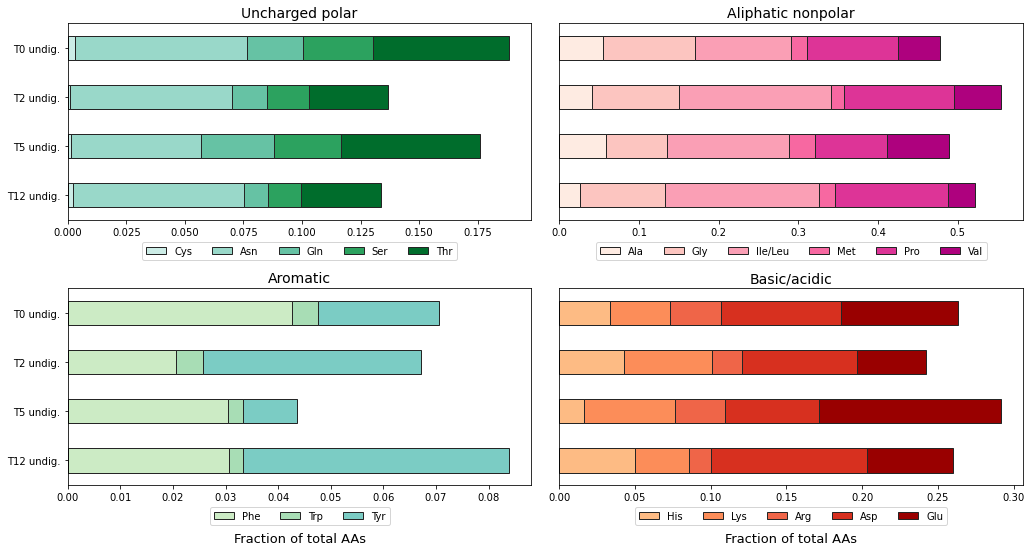

In [17]:
# plotting the NAAF-corrected AA compositions by residue type (charge, side group)
# order the horizontal bars by sample

sum_relAA_undig_des = sum_relAA_undig.sort_values('sample',ascending=False)

col_up = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
col_na = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
col_ar = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
col_ba = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'

# divide up the dataframe into 4 smaller dataframes based on AA class

# uncharged polar: cysteine, asparagine, glutamine, serine, threonine
up = sum_relAA_undig_des[['sample', 'C_RelNAAF', 'N_RelNAAF', 'Q_RelNAAF', 'S_RelNAAF', 'T_RelNAAF']].copy()
up_names = ['sample', 'Cys', 'Asn', 'Gln', 'Ser', 'Thr']
up.columns = up_names

# nonpolar, aliphatic R-group: alanine, glycine, methionine, proline, valine
na = sum_relAA_undig_des[['sample', 'A_RelNAAF', 'G_RelNAAF','I/L_RelNAAF', 'M_RelNAAF',\
                    'P_RelNAAF', 'V_RelNAAF']].copy()
na_names = ['sample', 'Ala', 'Gly', 'Ile/Leu', 'Met', 'Pro', 'Val']
na.columns = na_names

# aromatic R-group: phenylalanine, tryptophan, tyrosine
ar = sum_relAA_undig_des[['sample', 'F_RelNAAF', 'W_RelNAAF', 'Y_RelNAAF']].copy() 
ar_names = ['sample', 'Phe', 'Trp', 'Tyr']
ar.columns = ar_names

# basic and acidic R-group: hisdiine, lysine, arginine, aspartic acid, glutamic acid
ba = sum_relAA_undig_des[['sample', 'H_RelNAAF', 'K_RelNAAF', 'R_RelNAAF', 'D_RelNAAF', 'E_RelNAAF']].copy()
ba_names = ['sample', 'His', 'Lys', 'Arg', 'Asp', 'Glu']
ba.columns = ba_names

# plot AA comps

fig, axes = plt.subplots(figsize=(14, 7),nrows=2, ncols=2)
plt.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace= 0.06, hspace= 0.35)

up.plot(ax=axes[0,0], x='sample', kind='barh', stacked=True, color = col_up, edgecolor = '#252525')
na.plot(ax=axes[0,1], x='sample', kind='barh', stacked=True, color = col_na, edgecolor = '#252525')
ar.plot(ax=axes[1,0], x='sample', kind='barh', stacked=True, color = col_ar, edgecolor = '#252525')
ba.plot(ax=axes[1,1], x='sample', kind='barh', stacked=True, color = col_ba, edgecolor = '#252525')

axes[0,0].set_title('Uncharged polar', fontsize = 14)
axes[0,0].set_ylabel("")
axes[0,0].legend(bbox_to_anchor=(0.5, -0.09), loc='upper center', ncol=5)
axes[0,0].set_yticklabels( ('T12 undig.', 'T5 undig.', 'T2 undig.', 'T0 undig.') )

axes[0,1].set_title('Aliphatic nonpolar', fontsize = 14)
axes[0,1].yaxis.set_ticks([])
axes[0,1].set_ylabel("")
axes[0,1].legend(bbox_to_anchor=(0.5, -0.09), loc='upper center', ncol=6)

axes[1,0].set_title('Aromatic', fontsize = 14)
axes[1,0].set_xlabel('Fraction of total AAs', labelpad = 30, fontsize = 13)
axes[1,0].set_ylabel("")
axes[1,0].legend(bbox_to_anchor=(0.5, -0.09), loc='upper center', ncol=3)
axes[1,0].set_yticklabels( ('T12 undig.', 'T5 undig.', 'T2 undig.', 'T0 undig.') )

axes[1,1].set_title('Basic/acidic', fontsize = 14)
axes[1,1].yaxis.set_ticks([])
axes[1,1].set_xlabel('Fraction of total AAs', labelpad = 30, fontsize = 13)
axes[1,1].set_ylabel("")
axes[1,1].legend(bbox_to_anchor=(0.5, -0.09), loc='upper center', ncol=5)

#fig.suptitle('Relative amino acid composition of ETNP POM peptides', y = 1.07, size = 15)

# save figure in ptm-analyses dir
plt.savefig("/home/millieginty/Documents/git-repos/rot-mayer/analyses/AA-composition/undigested-DB+DN-AA-NAAFs.png", dpi = 300, bbox_inches='tight', transparent=True)

# also save in manuscript latex dir high res
#plt.savefig("/home/millieginty/Documents/git-repos/denovo-etnp/ETNP-AAs.png", dpi = 300, bbox_inches='tight')